### GAN 과 cGAN
---
![GAN](https://aiffelstaticprd.blob.core.windows.net/media/images/gan_img.max-800x600.png)
- Generator   
  노이즈 z(파란색)이 입력되고 특정 representation(검정색)으로 변환된 후 가짜 데이터 G(z)(빨간색)을 생성해 냅니다.
- Discriminator   
  실제 데이터 x와 Generator가 생성한 가짜 데이터 G(z)를 각각 입력받아 D(x) 및  D(G(z))(보라색)을 계산하여 진짜와 가짜를 식별해 냅니다.
  
![cGAN](https://aiffelstaticprd.blob.core.windows.net/media/images/cgan_img.max-800x600.png)
- Generator    
  노이즈 z(파란색)와 추가 정보 y(녹색)을 함께 입력받아 Generator 내부에서 결합되어 representation(검정색)으로 변환되며 가짜 데이터 G(zㅣy)를 생성합니다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 y는 레이블 정보이며, 일반적으로 one-hot 벡터를 입력으로 넣습니다.
- Discriminator  
  실제 데이터 x와 Generator가 생성한 가짜 데이터 G(zㅣy)를 각각 입력받으며, 마찬가지로 y 정보가 각각 함께 입력되어 진짜와 가짜를 식별합니다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 실제 데이터 x와 y는 알맞은 한 쌍("7"이라 쓰인 이미지의 경우 레이블도 7)을 이뤄야 하며, 마찬가지로 Generator에 입력된 x와 Discriminator에 입력되는 y는 동일한 레이블을 나타내야 합니다.

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 6GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
    except RuntimeError as e:
        print(e)

### Generator 구성
- pip install tensorflow-datasets

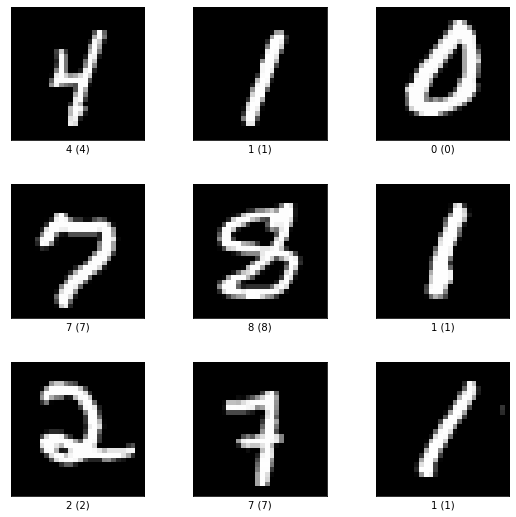

In [2]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

In [3]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


In [4]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.
# 이미지에 쓰인 숫자와 레이블이 일치해야 하고, 이미지 값의 범위가 -1~1 사이에 있어야 합니다.
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

Label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


#### GAN Generator

In [5]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()
        # 4개의 fully-connected 레이어 중 한 개를 제외하고 모두 ReLU 활성화를 사용하는 것으로 확인
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


#### cGAN Generator 구성

In [6]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        # 노이즈 입력 및 레이블 입력은 각각 1개의 fully-connected 레이어와 ReLU 활성화를 통과(dense_z, dense_y)  
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        # 각 결과가 서로 연결되어 다시 한번 1개의 fully-connected 레이어와 ReLU 활성화를 통과 (tf.concat, conbined_dense) 
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        # 1개의 fully-connected 레이어 및 Hyperbolic tangent 활성화를 거쳐 28x28 차원의 결과가 생성
        # (28,28,1) 크기의 이미지 형태로 변환되어 출력됩니다 (final_dense, reshape)
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


### Discriminator 구성

#### GAN Discriminator 구성

In [7]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


#### cGAN Discriminator 구성
- Maxout  
  두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오는 것.   
  

In [8]:
class Maxout(layers.Layer):
    # units 차원 수를 가진 fully-connected 레이어를 pieces개 만큼 만들고 그 중 최대 값을 출력
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

print("✅")

✅


In [9]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


### 학습 및 테스트

In [10]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


#### GAN으로 MNIST 학습

In [11]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


In [12]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.240199089050293, D:0.1363147348165512
[1/10 EPOCHS, 200 ITER] G:2.643437147140503, D:0.10650718212127686
[1/10 EPOCHS, 300 ITER] G:2.5449469089508057, D:0.1548902988433838
[1/10 EPOCHS, 400 ITER] G:2.8896124362945557, D:0.08236328512430191
[2/10 EPOCHS, 100 ITER] G:3.6674177646636963, D:0.058024849742650986
[2/10 EPOCHS, 200 ITER] G:2.766561985015869, D:0.14555320143699646
[2/10 EPOCHS, 300 ITER] G:2.529735565185547, D:0.1973763406276703
[2/10 EPOCHS, 400 ITER] G:2.6738710403442383, D:0.15558688342571259
[3/10 EPOCHS, 100 ITER] G:3.2016184329986572, D:0.2673863172531128
[3/10 EPOCHS, 200 ITER] G:4.122986316680908, D:0.1851266324520111
[3/10 EPOCHS, 300 ITER] G:3.4892544746398926, D:0.22411954402923584
[3/10 EPOCHS, 400 ITER] G:2.525853157043457, D:0.20478767156600952
[4/10 EPOCHS, 100 ITER] G:2.2505226135253906, D:0.19485771656036377
[4/10 EPOCHS, 200 ITER] G:2.706967353820801, D:0.1406809389591217
[4/10 EPOCHS, 300 ITER] G:3.407163143157959, D:0.09906414896

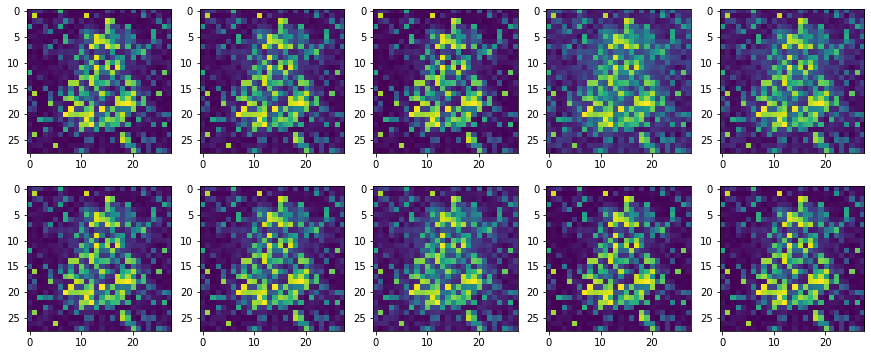

In [13]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

#### 500개의 학습된 GAN 데이터 다운로드
- mkdir -p ~/aiffel/conditional_generation/gan
- wget https://aiffelstaticprd.blob.core.windows.net/media/documents/GAN_500.zip
- mv GAN_500.zip ~/aiffel/conditional_generation/gan
- cd ~/aiffel/conditional_generation/gan && unzip GAN_500.zip

In [14]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

#### cGAN으로 MNIST 학습

In [15]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:5.0402069091796875, D:0.013017227873206139
[1/1 EPOCHS, 199 ITER] G:4.192083835601807, D:0.036856137216091156
[1/1 EPOCHS, 299 ITER] G:3.177192449569702, D:0.12768149375915527
[1/1 EPOCHS, 399 ITER] G:4.604147434234619, D:0.05097862333059311


#### 500개 학습 cGAN데이터 다운로드
- mkdir -p ~/aiffel/conditional_generation/cgan
- wget https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip
- mv CGAN_500.zip ~/aiffel/conditional_generation/cgan
- cd ~/aiffel/conditional_generation/cgan && unzip CGAN_500.zip

In [16]:
number =  7

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

### Pix2Pix - GAN 모델에 이미지 넣기
![pix2pix](https://aiffelstaticprd.blob.core.windows.net/media/images/p2p_results.max-800x600.png)


### Pix2Pix Generator
![pixgenerator](https://aiffelstaticprd.blob.core.windows.net/media/images/p2p_generator_unet.max-800x600.png)
- 각 레이어마다 Encoder와 Decoder가 연결(skip connection)되어 있어 Decoder가 변환된 이미지를 더 잘 생성하도록 Encoder로부터 더 많은 추가 정보를 이용합니다. 

### Pix2Pix Discriminator
![pixDiscriminator](https://aiffelstaticprd.blob.core.windows.net/media/images/patchgan.max-800x600.png)
- 하나의 이미지가 Discriminator의 입력으로 들어오면, convolution 레이어를 거쳐 확률값을 나타내는 최종 결과를 생성하는데, 그 결과는 하나의 값이 아닌 여러 개의 값을 갖습니다 (위 그림의 Prediction은 16개의 값을 가지고 있습니다). 위 그림에서 입력이미지의 파란색 점선은 여러 개의 출력 중 하나의 출력을 계산하기 위한 입력이미지의 receptive field 영역을 나타내고 있으며, 전체 영역을 다 보는 것이 아닌 일부 영역(파란색 점선)에 대해서만 진짜/가짜를 판별하는 하나의 확률값을 도출한다는 것입니다.

### 스케치에서 채색입히기

- wget https://aiffelstaticprd.blob.core.windows.net/media/documents/sketch2pokemon.zip
- mv sketch2pokemon.zip ~/aiffel/conditional_generation
- cd ~/aiffel/conditional_generation && unzip sketch2pokemon.zip

### 1. 데이터 준비

In [17]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [19]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [20]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [21]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    # 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    # 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    # 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop) 
    out = image.random_crop(padded, size=[256, 256, 6])
    # 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
    out = image.random_flip_left_right(out)
    # 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down) 
    out = image.random_flip_up_down(out)
    # 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


In [22]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

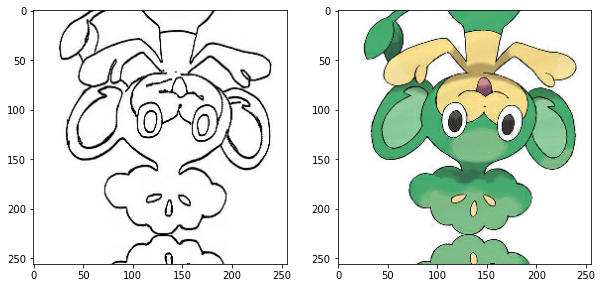

In [23]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

###  2. Generator 구성
![제네레이터](https://aiffelstaticprd.blob.core.windows.net/media/images/refer_g.max-800x600.png)

In [24]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [25]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [26]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [27]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [28]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [29]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


### 3. Generator 재구성

In [30]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [31]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [32]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

### 4. Discriminator 구성
![Discriminator](https://aiffelstaticprd.blob.core.windows.net/media/images/refer_d.max-800x600.png)

In [33]:
class DiscBlock(layers.Layer):
    # 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad),
    # BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


#### 문제. DiscBlock(n_filters=64, stride=1, custom_pad=True, use_bn=True, act=True) 으로 생성된 블록에 (width, height, channel) = (128, 128, 32) 크기가 입력되면 출력크기가 어떻게 변하는가?
- (128,128,32) 크기의 입력이 layers.ZeroPadding2D()를 통과하면, width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어납니다. 출력 : (130,130,32)
- 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어듭니다. 이는 OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1 의 식으로 계산할 수 있습니다. 채널 수는 사용한 필터 개수와 같습니다. 출력 : (127,127,64)
- 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않습니다.

In [34]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [35]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [36]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

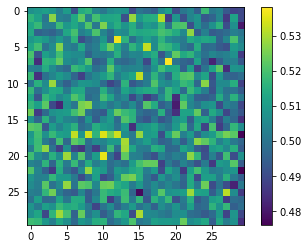

In [37]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

### 5. 학습 및 테스트

In [38]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


- Generator의 손실함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있습니다. 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산합니다.
  
- Discriminator의 손실함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교합니다.

In [39]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [40]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [41]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0010                     
L1_loss:0.4576                     
Discriminator_loss:1.1311

EPOCH[1] - STEP[20]                     
Generator_loss:0.5860                     
L1_loss:0.3019                     
Discriminator_loss:1.5537

EPOCH[1] - STEP[30]                     
Generator_loss:1.0363                     
L1_loss:0.2897                     
Discriminator_loss:1.1280

EPOCH[1] - STEP[40]                     
Generator_loss:0.8726                     
L1_loss:0.2857                     
Discriminator_loss:1.0730

EPOCH[1] - STEP[50]                     
Generator_loss:1.3895                     
L1_loss:0.2602                     
Discriminator_loss:0.6744

EPOCH[1] - STEP[60]                     
Generator_loss:2.1092                     
L1_loss:0.2362                     
Discriminator_loss:0.5553

EPOCH[1] - STEP[70]                     
Generator_loss:1.8627                     
L1_loss:0.2583                    

EPOCH[3] - STEP[170]                     
Generator_loss:0.5597                     
L1_loss:0.2419                     
Discriminator_loss:2.7373

EPOCH[3] - STEP[180]                     
Generator_loss:1.9020                     
L1_loss:0.3081                     
Discriminator_loss:0.7936

EPOCH[3] - STEP[190]                     
Generator_loss:3.4013                     
L1_loss:0.2896                     
Discriminator_loss:2.1105

EPOCH[3] - STEP[200]                     
Generator_loss:1.0373                     
L1_loss:0.3002                     
Discriminator_loss:0.5114

EPOCH[4] - STEP[10]                     
Generator_loss:1.0762                     
L1_loss:0.2708                     
Discriminator_loss:0.5891

EPOCH[4] - STEP[20]                     
Generator_loss:1.9751                     
L1_loss:0.2262                     
Discriminator_loss:0.5233

EPOCH[4] - STEP[30]                     
Generator_loss:2.1259                     
L1_loss:0.2289                

EPOCH[6] - STEP[130]                     
Generator_loss:2.2918                     
L1_loss:0.2280                     
Discriminator_loss:0.2545

EPOCH[6] - STEP[140]                     
Generator_loss:0.6840                     
L1_loss:0.2670                     
Discriminator_loss:0.9725

EPOCH[6] - STEP[150]                     
Generator_loss:1.0994                     
L1_loss:0.2576                     
Discriminator_loss:0.4782

EPOCH[6] - STEP[160]                     
Generator_loss:2.8691                     
L1_loss:0.2266                     
Discriminator_loss:0.6030

EPOCH[6] - STEP[170]                     
Generator_loss:1.0839                     
L1_loss:0.2526                     
Discriminator_loss:0.6908

EPOCH[6] - STEP[180]                     
Generator_loss:1.0759                     
L1_loss:0.2429                     
Discriminator_loss:0.5160

EPOCH[6] - STEP[190]                     
Generator_loss:2.0028                     
L1_loss:0.1939             

EPOCH[9] - STEP[90]                     
Generator_loss:2.9688                     
L1_loss:0.2502                     
Discriminator_loss:0.3580

EPOCH[9] - STEP[100]                     
Generator_loss:2.3038                     
L1_loss:0.2138                     
Discriminator_loss:0.4733

EPOCH[9] - STEP[110]                     
Generator_loss:1.3259                     
L1_loss:0.2068                     
Discriminator_loss:0.5537

EPOCH[9] - STEP[120]                     
Generator_loss:2.6865                     
L1_loss:0.2595                     
Discriminator_loss:0.8708

EPOCH[9] - STEP[130]                     
Generator_loss:2.2758                     
L1_loss:0.2320                     
Discriminator_loss:1.9853

EPOCH[9] - STEP[140]                     
Generator_loss:2.2018                     
L1_loss:0.2315                     
Discriminator_loss:0.5504

EPOCH[9] - STEP[150]                     
Generator_loss:1.3302                     
L1_loss:0.2479              

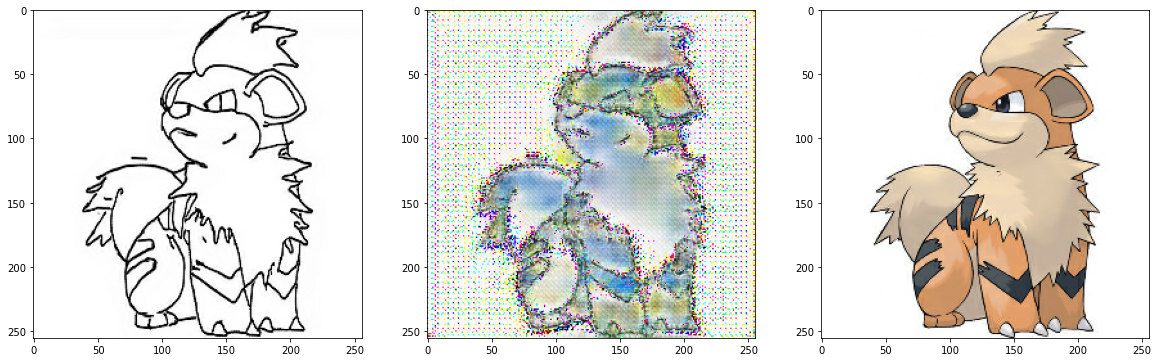

In [42]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

### 프로젝트 : Segmentation map으로 도로 이미지 만들기

- wget https://aiffelstaticprd.blob.core.windows.net/media/documents/cityscapes.zip
- mv cityscapes.zip ~/aiffel/conditional_generation
- cd ~/aiffel/conditional_generation && unzip cityscapes.zip

In [43]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


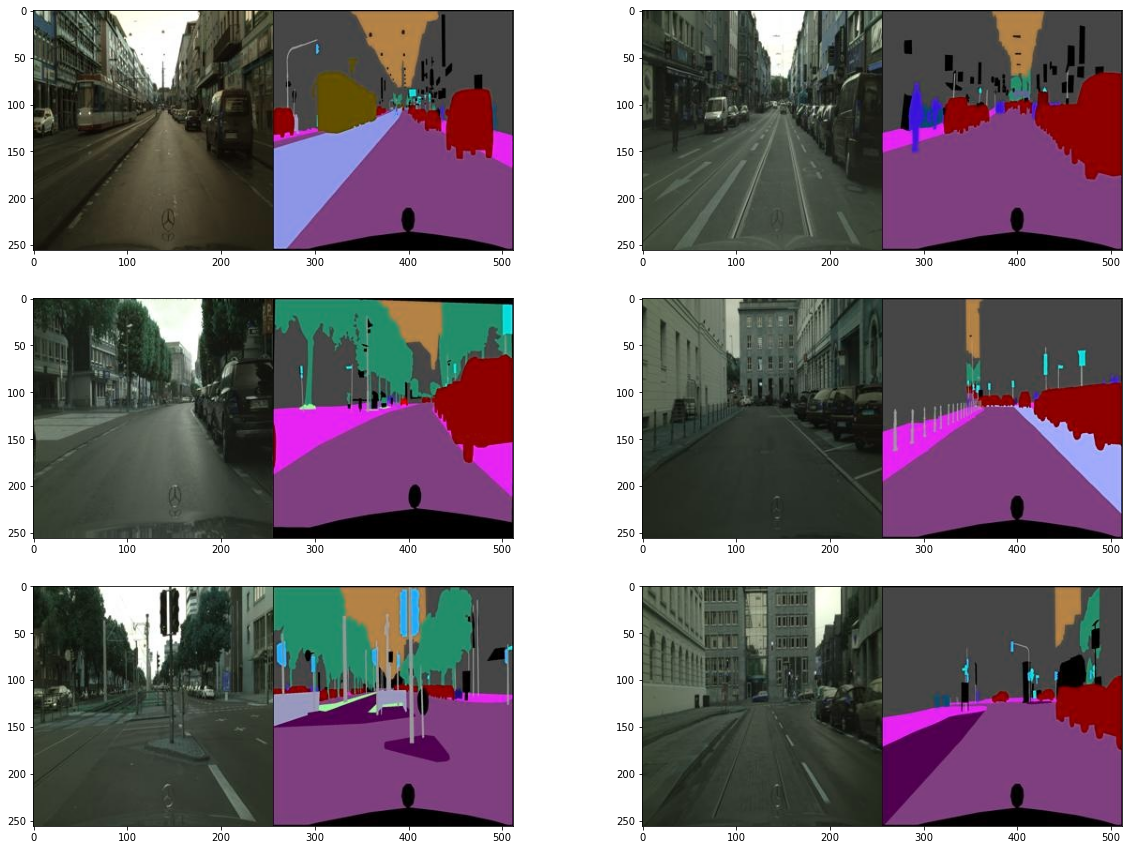

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [45]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


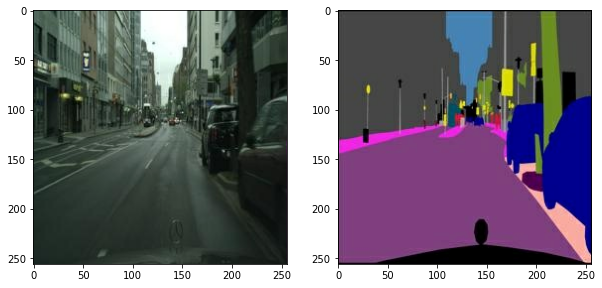

In [46]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [47]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    # 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    # 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    # 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop) 
    out = image.random_crop(padded, size=[256, 256, 6])
    # 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
    out = image.random_flip_left_right(out)
    # 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down) 
    out = image.random_flip_up_down(out)
    # 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


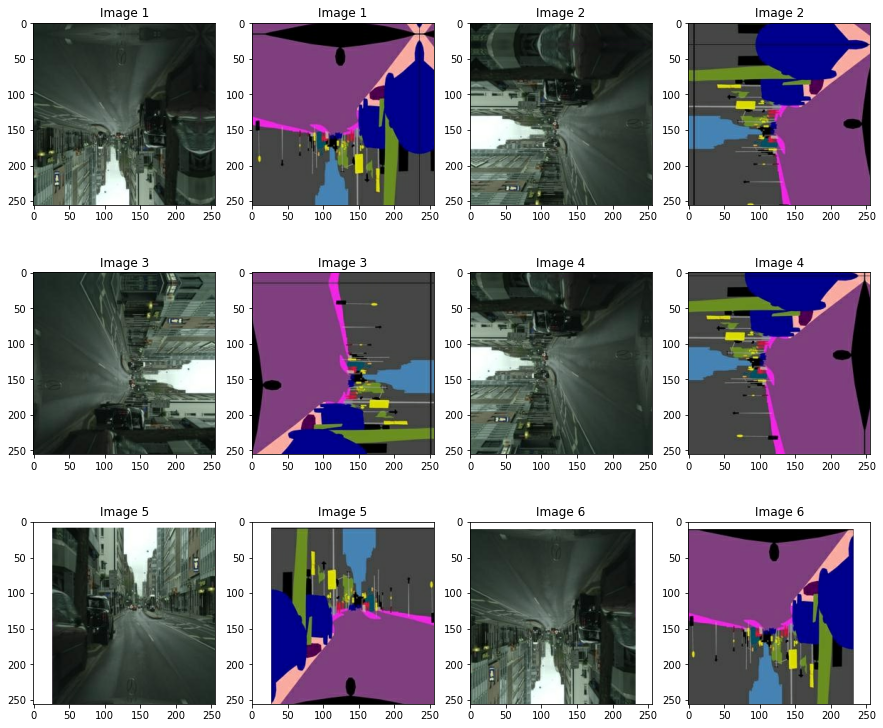

In [48]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

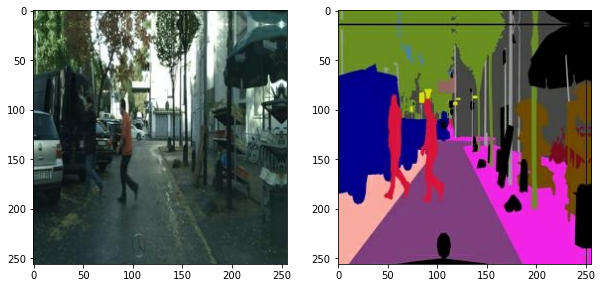

In [49]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [50]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [51]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [52]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [53]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [54]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [55]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0182                     
L1_loss:0.3299                     
Discriminator_loss:1.3014

EPOCH[1] - STEP[20]                     
Generator_loss:1.0729                     
L1_loss:0.2931                     
Discriminator_loss:1.1077

EPOCH[1] - STEP[30]                     
Generator_loss:1.0560                     
L1_loss:0.2472                     
Discriminator_loss:1.0431

EPOCH[1] - STEP[40]                     
Generator_loss:1.3779                     
L1_loss:0.2656                     
Discriminator_loss:0.8751

EPOCH[1] - STEP[50]                     
Generator_loss:1.8046                     
L1_loss:0.2758                     
Discriminator_loss:0.7800

EPOCH[1] - STEP[60]                     
Generator_loss:2.1296                     
L1_loss:0.2179                     
Discriminator_loss:0.9494

EPOCH[1] - STEP[70]                     
Generator_loss:1.7512                     
L1_loss:0.2686                    

EPOCH[3] - STEP[70]                     
Generator_loss:3.2096                     
L1_loss:0.1930                     
Discriminator_loss:0.3489

EPOCH[3] - STEP[80]                     
Generator_loss:1.9215                     
L1_loss:0.1903                     
Discriminator_loss:0.4331

EPOCH[3] - STEP[90]                     
Generator_loss:2.5864                     
L1_loss:0.2347                     
Discriminator_loss:0.5793

EPOCH[3] - STEP[100]                     
Generator_loss:2.8605                     
L1_loss:0.1837                     
Discriminator_loss:1.2082

EPOCH[3] - STEP[110]                     
Generator_loss:2.8447                     
L1_loss:0.2047                     
Discriminator_loss:0.3981

EPOCH[3] - STEP[120]                     
Generator_loss:0.8969                     
L1_loss:0.1967                     
Discriminator_loss:1.1780

EPOCH[3] - STEP[130]                     
Generator_loss:1.7992                     
L1_loss:0.1938                

EPOCH[5] - STEP[130]                     
Generator_loss:0.5562                     
L1_loss:0.2175                     
Discriminator_loss:1.0411

EPOCH[5] - STEP[140]                     
Generator_loss:0.7539                     
L1_loss:0.2009                     
Discriminator_loss:1.1294

EPOCH[5] - STEP[150]                     
Generator_loss:2.0005                     
L1_loss:0.2193                     
Discriminator_loss:0.3862

EPOCH[5] - STEP[160]                     
Generator_loss:1.1724                     
L1_loss:0.2256                     
Discriminator_loss:0.5643

EPOCH[5] - STEP[170]                     
Generator_loss:2.0790                     
L1_loss:0.1694                     
Discriminator_loss:0.3509

EPOCH[5] - STEP[180]                     
Generator_loss:1.0367                     
L1_loss:0.1869                     
Discriminator_loss:1.4798

EPOCH[5] - STEP[190]                     
Generator_loss:2.0398                     
L1_loss:0.2226             

EPOCH[7] - STEP[190]                     
Generator_loss:2.4888                     
L1_loss:0.1970                     
Discriminator_loss:0.2876

EPOCH[7] - STEP[200]                     
Generator_loss:2.6934                     
L1_loss:0.1839                     
Discriminator_loss:0.4688

EPOCH[7] - STEP[210]                     
Generator_loss:1.8096                     
L1_loss:0.2043                     
Discriminator_loss:0.4269

EPOCH[7] - STEP[220]                     
Generator_loss:1.9317                     
L1_loss:0.2245                     
Discriminator_loss:0.5684

EPOCH[7] - STEP[230]                     
Generator_loss:2.6161                     
L1_loss:0.2068                     
Discriminator_loss:0.3311

EPOCH[7] - STEP[240]                     
Generator_loss:0.7693                     
L1_loss:0.2013                     
Discriminator_loss:1.1125

EPOCH[7] - STEP[250]                     
Generator_loss:2.1291                     
L1_loss:0.1515             

EPOCH[9] - STEP[250]                     
Generator_loss:1.0371                     
L1_loss:0.1621                     
Discriminator_loss:1.1358

EPOCH[10] - STEP[10]                     
Generator_loss:1.4017                     
L1_loss:0.1790                     
Discriminator_loss:0.8292

EPOCH[10] - STEP[20]                     
Generator_loss:2.0445                     
L1_loss:0.1432                     
Discriminator_loss:0.6323

EPOCH[10] - STEP[30]                     
Generator_loss:1.9258                     
L1_loss:0.1712                     
Discriminator_loss:0.7184

EPOCH[10] - STEP[40]                     
Generator_loss:2.5222                     
L1_loss:0.1523                     
Discriminator_loss:0.4849

EPOCH[10] - STEP[50]                     
Generator_loss:2.7685                     
L1_loss:0.1882                     
Discriminator_loss:0.2369

EPOCH[10] - STEP[60]                     
Generator_loss:0.8931                     
L1_loss:0.1883             

EPOCH[12] - STEP[60]                     
Generator_loss:1.6890                     
L1_loss:0.1833                     
Discriminator_loss:1.0867

EPOCH[12] - STEP[70]                     
Generator_loss:2.2708                     
L1_loss:0.1273                     
Discriminator_loss:1.7880

EPOCH[12] - STEP[80]                     
Generator_loss:1.0316                     
L1_loss:0.1712                     
Discriminator_loss:0.6845

EPOCH[12] - STEP[90]                     
Generator_loss:0.7486                     
L1_loss:0.1841                     
Discriminator_loss:0.8639

EPOCH[12] - STEP[100]                     
Generator_loss:0.9023                     
L1_loss:0.2008                     
Discriminator_loss:0.9265

EPOCH[12] - STEP[110]                     
Generator_loss:1.1877                     
L1_loss:0.1552                     
Discriminator_loss:0.5353

EPOCH[12] - STEP[120]                     
Generator_loss:0.4855                     
L1_loss:0.1592          

EPOCH[14] - STEP[120]                     
Generator_loss:1.3167                     
L1_loss:0.1653                     
Discriminator_loss:0.5648

EPOCH[14] - STEP[130]                     
Generator_loss:1.4514                     
L1_loss:0.1887                     
Discriminator_loss:0.4763

EPOCH[14] - STEP[140]                     
Generator_loss:0.7604                     
L1_loss:0.1740                     
Discriminator_loss:1.0955

EPOCH[14] - STEP[150]                     
Generator_loss:1.8802                     
L1_loss:0.1776                     
Discriminator_loss:0.5519

EPOCH[14] - STEP[160]                     
Generator_loss:2.1347                     
L1_loss:0.1773                     
Discriminator_loss:0.4320

EPOCH[14] - STEP[170]                     
Generator_loss:2.6660                     
L1_loss:0.2344                     
Discriminator_loss:0.1745

EPOCH[14] - STEP[180]                     
Generator_loss:1.4931                     
L1_loss:0.1801      

EPOCH[16] - STEP[180]                     
Generator_loss:0.2557                     
L1_loss:0.1826                     
Discriminator_loss:1.9336

EPOCH[16] - STEP[190]                     
Generator_loss:2.8200                     
L1_loss:0.1223                     
Discriminator_loss:2.1275

EPOCH[16] - STEP[200]                     
Generator_loss:1.8737                     
L1_loss:0.1435                     
Discriminator_loss:0.9226

EPOCH[16] - STEP[210]                     
Generator_loss:2.8618                     
L1_loss:0.2138                     
Discriminator_loss:0.1248

EPOCH[16] - STEP[220]                     
Generator_loss:2.5447                     
L1_loss:0.1946                     
Discriminator_loss:0.1619

EPOCH[16] - STEP[230]                     
Generator_loss:4.2107                     
L1_loss:0.1660                     
Discriminator_loss:1.5999

EPOCH[16] - STEP[240]                     
Generator_loss:3.1093                     
L1_loss:0.1516      

EPOCH[18] - STEP[240]                     
Generator_loss:2.5538                     
L1_loss:0.2118                     
Discriminator_loss:0.3051

EPOCH[18] - STEP[250]                     
Generator_loss:1.7235                     
L1_loss:0.1457                     
Discriminator_loss:1.0605

EPOCH[19] - STEP[10]                     
Generator_loss:2.1719                     
L1_loss:0.1963                     
Discriminator_loss:0.2263

EPOCH[19] - STEP[20]                     
Generator_loss:3.3502                     
L1_loss:0.1431                     
Discriminator_loss:0.4208

EPOCH[19] - STEP[30]                     
Generator_loss:2.6665                     
L1_loss:0.1864                     
Discriminator_loss:0.4214

EPOCH[19] - STEP[40]                     
Generator_loss:1.6809                     
L1_loss:0.1783                     
Discriminator_loss:0.3480

EPOCH[19] - STEP[50]                     
Generator_loss:2.0954                     
L1_loss:0.1919           

EPOCH[21] - STEP[50]                     
Generator_loss:0.7339                     
L1_loss:0.1580                     
Discriminator_loss:0.9754

EPOCH[21] - STEP[60]                     
Generator_loss:2.9595                     
L1_loss:0.1736                     
Discriminator_loss:0.6324

EPOCH[21] - STEP[70]                     
Generator_loss:2.5678                     
L1_loss:0.1730                     
Discriminator_loss:0.2308

EPOCH[21] - STEP[80]                     
Generator_loss:1.6488                     
L1_loss:0.1920                     
Discriminator_loss:0.4831

EPOCH[21] - STEP[90]                     
Generator_loss:0.5466                     
L1_loss:0.1973                     
Discriminator_loss:1.1772

EPOCH[21] - STEP[100]                     
Generator_loss:1.7809                     
L1_loss:0.1497                     
Discriminator_loss:0.8700

EPOCH[21] - STEP[110]                     
Generator_loss:2.2575                     
L1_loss:0.1696           

EPOCH[23] - STEP[110]                     
Generator_loss:0.7488                     
L1_loss:0.1885                     
Discriminator_loss:1.1145

EPOCH[23] - STEP[120]                     
Generator_loss:1.7071                     
L1_loss:0.1426                     
Discriminator_loss:0.9122

EPOCH[23] - STEP[130]                     
Generator_loss:1.3946                     
L1_loss:0.1640                     
Discriminator_loss:0.6767

EPOCH[23] - STEP[140]                     
Generator_loss:2.4193                     
L1_loss:0.1684                     
Discriminator_loss:0.4273

EPOCH[23] - STEP[150]                     
Generator_loss:2.5386                     
L1_loss:0.1595                     
Discriminator_loss:0.6439

EPOCH[23] - STEP[160]                     
Generator_loss:1.8963                     
L1_loss:0.1286                     
Discriminator_loss:0.7118

EPOCH[23] - STEP[170]                     
Generator_loss:2.7557                     
L1_loss:0.1635      

EPOCH[25] - STEP[170]                     
Generator_loss:0.7444                     
L1_loss:0.1719                     
Discriminator_loss:1.0784

EPOCH[25] - STEP[180]                     
Generator_loss:3.9574                     
L1_loss:0.1672                     
Discriminator_loss:0.7900

EPOCH[25] - STEP[190]                     
Generator_loss:1.9953                     
L1_loss:0.2024                     
Discriminator_loss:0.4003

EPOCH[25] - STEP[200]                     
Generator_loss:1.1074                     
L1_loss:0.1428                     
Discriminator_loss:0.7803

EPOCH[25] - STEP[210]                     
Generator_loss:1.3038                     
L1_loss:0.1574                     
Discriminator_loss:0.4880

EPOCH[25] - STEP[220]                     
Generator_loss:3.9099                     
L1_loss:0.1545                     
Discriminator_loss:0.9794

EPOCH[25] - STEP[230]                     
Generator_loss:0.7460                     
L1_loss:0.1548      

EPOCH[27] - STEP[230]                     
Generator_loss:0.4382                     
L1_loss:0.1687                     
Discriminator_loss:1.4495

EPOCH[27] - STEP[240]                     
Generator_loss:1.7888                     
L1_loss:0.1748                     
Discriminator_loss:0.8231

EPOCH[27] - STEP[250]                     
Generator_loss:1.9385                     
L1_loss:0.1312                     
Discriminator_loss:0.5813

EPOCH[28] - STEP[10]                     
Generator_loss:0.9979                     
L1_loss:0.1682                     
Discriminator_loss:0.6948

EPOCH[28] - STEP[20]                     
Generator_loss:1.0120                     
L1_loss:0.1485                     
Discriminator_loss:0.6027

EPOCH[28] - STEP[30]                     
Generator_loss:1.5555                     
L1_loss:0.1164                     
Discriminator_loss:0.6431

EPOCH[28] - STEP[40]                     
Generator_loss:2.7269                     
L1_loss:0.1527          

EPOCH[30] - STEP[40]                     
Generator_loss:0.1483                     
L1_loss:0.1728                     
Discriminator_loss:2.7650

EPOCH[30] - STEP[50]                     
Generator_loss:2.4687                     
L1_loss:0.1213                     
Discriminator_loss:0.9300

EPOCH[30] - STEP[60]                     
Generator_loss:2.9123                     
L1_loss:0.1515                     
Discriminator_loss:0.5260

EPOCH[30] - STEP[70]                     
Generator_loss:3.1343                     
L1_loss:0.1415                     
Discriminator_loss:0.7773

EPOCH[30] - STEP[80]                     
Generator_loss:0.8131                     
L1_loss:0.2012                     
Discriminator_loss:0.9032

EPOCH[30] - STEP[90]                     
Generator_loss:2.8403                     
L1_loss:0.1119                     
Discriminator_loss:1.0395

EPOCH[30] - STEP[100]                     
Generator_loss:1.7164                     
L1_loss:0.1501            

EPOCH[32] - STEP[100]                     
Generator_loss:2.6949                     
L1_loss:0.1920                     
Discriminator_loss:0.2384

EPOCH[32] - STEP[110]                     
Generator_loss:2.2222                     
L1_loss:0.1479                     
Discriminator_loss:0.2804

EPOCH[32] - STEP[120]                     
Generator_loss:2.7415                     
L1_loss:0.1628                     
Discriminator_loss:0.5368

EPOCH[32] - STEP[130]                     
Generator_loss:0.3792                     
L1_loss:0.1483                     
Discriminator_loss:1.6180

EPOCH[32] - STEP[140]                     
Generator_loss:2.4208                     
L1_loss:0.1213                     
Discriminator_loss:0.3794

EPOCH[32] - STEP[150]                     
Generator_loss:3.8409                     
L1_loss:0.1709                     
Discriminator_loss:0.6962

EPOCH[32] - STEP[160]                     
Generator_loss:1.5893                     
L1_loss:0.1313      

EPOCH[34] - STEP[160]                     
Generator_loss:1.5116                     
L1_loss:0.1873                     
Discriminator_loss:0.3641

EPOCH[34] - STEP[170]                     
Generator_loss:3.6296                     
L1_loss:0.1771                     
Discriminator_loss:0.1067

EPOCH[34] - STEP[180]                     
Generator_loss:2.3652                     
L1_loss:0.1698                     
Discriminator_loss:0.2014

EPOCH[34] - STEP[190]                     
Generator_loss:3.2404                     
L1_loss:0.1370                     
Discriminator_loss:0.6049

EPOCH[34] - STEP[200]                     
Generator_loss:2.0981                     
L1_loss:0.1613                     
Discriminator_loss:0.5495

EPOCH[34] - STEP[210]                     
Generator_loss:2.0560                     
L1_loss:0.1582                     
Discriminator_loss:0.9387

EPOCH[34] - STEP[220]                     
Generator_loss:2.1536                     
L1_loss:0.1781      

EPOCH[36] - STEP[220]                     
Generator_loss:3.1871                     
L1_loss:0.1509                     
Discriminator_loss:0.5042

EPOCH[36] - STEP[230]                     
Generator_loss:3.8222                     
L1_loss:0.1389                     
Discriminator_loss:1.5678

EPOCH[36] - STEP[240]                     
Generator_loss:3.0491                     
L1_loss:0.1663                     
Discriminator_loss:0.3184

EPOCH[36] - STEP[250]                     
Generator_loss:2.0575                     
L1_loss:0.1504                     
Discriminator_loss:0.3622

EPOCH[37] - STEP[10]                     
Generator_loss:1.7552                     
L1_loss:0.1366                     
Discriminator_loss:0.7152

EPOCH[37] - STEP[20]                     
Generator_loss:3.8424                     
L1_loss:0.1353                     
Discriminator_loss:0.6125

EPOCH[37] - STEP[30]                     
Generator_loss:3.3358                     
L1_loss:0.1440         

EPOCH[39] - STEP[30]                     
Generator_loss:3.2512                     
L1_loss:0.1434                     
Discriminator_loss:0.2492

EPOCH[39] - STEP[40]                     
Generator_loss:0.9985                     
L1_loss:0.1589                     
Discriminator_loss:0.6705

EPOCH[39] - STEP[50]                     
Generator_loss:3.4428                     
L1_loss:0.1374                     
Discriminator_loss:0.2434

EPOCH[39] - STEP[60]                     
Generator_loss:3.4926                     
L1_loss:0.1286                     
Discriminator_loss:1.8871

EPOCH[39] - STEP[70]                     
Generator_loss:2.7661                     
L1_loss:0.1567                     
Discriminator_loss:0.2407

EPOCH[39] - STEP[80]                     
Generator_loss:2.7587                     
L1_loss:0.1763                     
Discriminator_loss:0.1649

EPOCH[39] - STEP[90]                     
Generator_loss:4.5036                     
L1_loss:0.1456             

EPOCH[41] - STEP[90]                     
Generator_loss:1.9922                     
L1_loss:0.1434                     
Discriminator_loss:0.4251

EPOCH[41] - STEP[100]                     
Generator_loss:3.5809                     
L1_loss:0.1601                     
Discriminator_loss:0.1391

EPOCH[41] - STEP[110]                     
Generator_loss:2.0838                     
L1_loss:0.1863                     
Discriminator_loss:0.2230

EPOCH[41] - STEP[120]                     
Generator_loss:2.6303                     
L1_loss:0.1581                     
Discriminator_loss:0.2689

EPOCH[41] - STEP[130]                     
Generator_loss:0.9426                     
L1_loss:0.1459                     
Discriminator_loss:1.0754

EPOCH[41] - STEP[140]                     
Generator_loss:1.2507                     
L1_loss:0.1567                     
Discriminator_loss:0.6472

EPOCH[41] - STEP[150]                     
Generator_loss:1.1324                     
L1_loss:0.1634       

EPOCH[43] - STEP[150]                     
Generator_loss:3.1927                     
L1_loss:0.1625                     
Discriminator_loss:0.1421

EPOCH[43] - STEP[160]                     
Generator_loss:4.1676                     
L1_loss:0.1076                     
Discriminator_loss:0.6881

EPOCH[43] - STEP[170]                     
Generator_loss:4.9585                     
L1_loss:0.1494                     
Discriminator_loss:2.1279

EPOCH[43] - STEP[180]                     
Generator_loss:3.8453                     
L1_loss:0.1726                     
Discriminator_loss:0.0652

EPOCH[43] - STEP[190]                     
Generator_loss:3.9112                     
L1_loss:0.1541                     
Discriminator_loss:0.4070

EPOCH[43] - STEP[200]                     
Generator_loss:0.8914                     
L1_loss:0.1393                     
Discriminator_loss:0.7998

EPOCH[43] - STEP[210]                     
Generator_loss:1.9256                     
L1_loss:0.1832      

EPOCH[45] - STEP[210]                     
Generator_loss:1.3327                     
L1_loss:0.1654                     
Discriminator_loss:0.6335

EPOCH[45] - STEP[220]                     
Generator_loss:3.8439                     
L1_loss:0.1374                     
Discriminator_loss:0.5083

EPOCH[45] - STEP[230]                     
Generator_loss:2.6671                     
L1_loss:0.1476                     
Discriminator_loss:0.1316

EPOCH[45] - STEP[240]                     
Generator_loss:4.3360                     
L1_loss:0.1453                     
Discriminator_loss:0.3686

EPOCH[45] - STEP[250]                     
Generator_loss:4.2684                     
L1_loss:0.1569                     
Discriminator_loss:0.1541

EPOCH[46] - STEP[10]                     
Generator_loss:2.2669                     
L1_loss:0.1808                     
Discriminator_loss:0.2648

EPOCH[46] - STEP[20]                     
Generator_loss:3.4792                     
L1_loss:0.1427        

EPOCH[48] - STEP[20]                     
Generator_loss:3.3471                     
L1_loss:0.1296                     
Discriminator_loss:0.2317

EPOCH[48] - STEP[30]                     
Generator_loss:0.5012                     
L1_loss:0.1405                     
Discriminator_loss:1.5731

EPOCH[48] - STEP[40]                     
Generator_loss:2.4742                     
L1_loss:0.1847                     
Discriminator_loss:0.1428

EPOCH[48] - STEP[50]                     
Generator_loss:1.6819                     
L1_loss:0.1155                     
Discriminator_loss:1.1544

EPOCH[48] - STEP[60]                     
Generator_loss:3.8762                     
L1_loss:0.1447                     
Discriminator_loss:0.1874

EPOCH[48] - STEP[70]                     
Generator_loss:4.3160                     
L1_loss:0.1394                     
Discriminator_loss:0.6284

EPOCH[48] - STEP[80]                     
Generator_loss:0.9528                     
L1_loss:0.1632             

EPOCH[50] - STEP[80]                     
Generator_loss:1.5169                     
L1_loss:0.1407                     
Discriminator_loss:0.5772

EPOCH[50] - STEP[90]                     
Generator_loss:3.3737                     
L1_loss:0.1200                     
Discriminator_loss:1.0938

EPOCH[50] - STEP[100]                     
Generator_loss:3.0142                     
L1_loss:0.1864                     
Discriminator_loss:0.0987

EPOCH[50] - STEP[110]                     
Generator_loss:2.0025                     
L1_loss:0.1735                     
Discriminator_loss:0.3304

EPOCH[50] - STEP[120]                     
Generator_loss:1.0788                     
L1_loss:0.1334                     
Discriminator_loss:0.6535

EPOCH[50] - STEP[130]                     
Generator_loss:5.1303                     
L1_loss:0.1304                     
Discriminator_loss:1.0167

EPOCH[50] - STEP[140]                     
Generator_loss:2.4957                     
L1_loss:0.1797        

EPOCH[52] - STEP[140]                     
Generator_loss:2.7772                     
L1_loss:0.1120                     
Discriminator_loss:0.7741

EPOCH[52] - STEP[150]                     
Generator_loss:2.0549                     
L1_loss:0.1510                     
Discriminator_loss:0.9362

EPOCH[52] - STEP[160]                     
Generator_loss:1.6618                     
L1_loss:0.1365                     
Discriminator_loss:0.3800

EPOCH[52] - STEP[170]                     
Generator_loss:1.5860                     
L1_loss:0.1355                     
Discriminator_loss:0.5533

EPOCH[52] - STEP[180]                     
Generator_loss:2.3430                     
L1_loss:0.1391                     
Discriminator_loss:0.2790

EPOCH[52] - STEP[190]                     
Generator_loss:5.8346                     
L1_loss:0.1452                     
Discriminator_loss:1.2600

EPOCH[52] - STEP[200]                     
Generator_loss:3.1679                     
L1_loss:0.1132      

EPOCH[54] - STEP[200]                     
Generator_loss:1.1513                     
L1_loss:0.1341                     
Discriminator_loss:0.6266

EPOCH[54] - STEP[210]                     
Generator_loss:2.6582                     
L1_loss:0.1470                     
Discriminator_loss:0.3340

EPOCH[54] - STEP[220]                     
Generator_loss:2.0314                     
L1_loss:0.1372                     
Discriminator_loss:0.2424

EPOCH[54] - STEP[230]                     
Generator_loss:4.3644                     
L1_loss:0.1408                     
Discriminator_loss:0.1008

EPOCH[54] - STEP[240]                     
Generator_loss:4.4186                     
L1_loss:0.1270                     
Discriminator_loss:0.2051

EPOCH[54] - STEP[250]                     
Generator_loss:3.0888                     
L1_loss:0.1708                     
Discriminator_loss:0.6256

EPOCH[55] - STEP[10]                     
Generator_loss:4.4455                     
L1_loss:0.1236       

EPOCH[57] - STEP[10]                     
Generator_loss:0.8382                     
L1_loss:0.1145                     
Discriminator_loss:0.8254

EPOCH[57] - STEP[20]                     
Generator_loss:3.3584                     
L1_loss:0.1189                     
Discriminator_loss:0.4470

EPOCH[57] - STEP[30]                     
Generator_loss:1.0251                     
L1_loss:0.1550                     
Discriminator_loss:0.6904

EPOCH[57] - STEP[40]                     
Generator_loss:2.9158                     
L1_loss:0.1395                     
Discriminator_loss:0.3009

EPOCH[57] - STEP[50]                     
Generator_loss:0.8636                     
L1_loss:0.1613                     
Discriminator_loss:0.9814

EPOCH[57] - STEP[60]                     
Generator_loss:3.3707                     
L1_loss:0.1266                     
Discriminator_loss:0.2683

EPOCH[57] - STEP[70]                     
Generator_loss:4.4006                     
L1_loss:0.1403             

EPOCH[59] - STEP[70]                     
Generator_loss:4.7929                     
L1_loss:0.1140                     
Discriminator_loss:0.2602

EPOCH[59] - STEP[80]                     
Generator_loss:2.4559                     
L1_loss:0.1527                     
Discriminator_loss:0.2532

EPOCH[59] - STEP[90]                     
Generator_loss:2.6902                     
L1_loss:0.1298                     
Discriminator_loss:0.1710

EPOCH[59] - STEP[100]                     
Generator_loss:4.0541                     
L1_loss:0.1074                     
Discriminator_loss:0.7672

EPOCH[59] - STEP[110]                     
Generator_loss:4.7199                     
L1_loss:0.1544                     
Discriminator_loss:0.1632

EPOCH[59] - STEP[120]                     
Generator_loss:2.8506                     
L1_loss:0.1386                     
Discriminator_loss:0.3112

EPOCH[59] - STEP[130]                     
Generator_loss:2.9740                     
L1_loss:0.1905         

EPOCH[61] - STEP[130]                     
Generator_loss:3.9217                     
L1_loss:0.1286                     
Discriminator_loss:0.1355

EPOCH[61] - STEP[140]                     
Generator_loss:1.8725                     
L1_loss:0.1445                     
Discriminator_loss:0.2577

EPOCH[61] - STEP[150]                     
Generator_loss:4.6682                     
L1_loss:0.1646                     
Discriminator_loss:0.4155

EPOCH[61] - STEP[160]                     
Generator_loss:1.3746                     
L1_loss:0.1572                     
Discriminator_loss:0.5218

EPOCH[61] - STEP[170]                     
Generator_loss:2.4807                     
L1_loss:0.1756                     
Discriminator_loss:0.2198

EPOCH[61] - STEP[180]                     
Generator_loss:4.3846                     
L1_loss:0.1421                     
Discriminator_loss:0.7530

EPOCH[61] - STEP[190]                     
Generator_loss:2.8164                     
L1_loss:0.1412      

EPOCH[63] - STEP[190]                     
Generator_loss:1.0117                     
L1_loss:0.1426                     
Discriminator_loss:0.7406

EPOCH[63] - STEP[200]                     
Generator_loss:2.2488                     
L1_loss:0.1125                     
Discriminator_loss:0.4035

EPOCH[63] - STEP[210]                     
Generator_loss:2.3877                     
L1_loss:0.1089                     
Discriminator_loss:0.5511

EPOCH[63] - STEP[220]                     
Generator_loss:4.1021                     
L1_loss:0.1406                     
Discriminator_loss:0.2568

EPOCH[63] - STEP[230]                     
Generator_loss:2.5708                     
L1_loss:0.1570                     
Discriminator_loss:0.4022

EPOCH[63] - STEP[240]                     
Generator_loss:3.8167                     
L1_loss:0.1050                     
Discriminator_loss:1.6404

EPOCH[63] - STEP[250]                     
Generator_loss:2.9346                     
L1_loss:0.1447      

EPOCH[65] - STEP[250]                     
Generator_loss:2.6796                     
L1_loss:0.1583                     
Discriminator_loss:0.1801

EPOCH[66] - STEP[10]                     
Generator_loss:4.8112                     
L1_loss:0.1220                     
Discriminator_loss:1.3055

EPOCH[66] - STEP[20]                     
Generator_loss:1.1131                     
L1_loss:0.1091                     
Discriminator_loss:0.7320

EPOCH[66] - STEP[30]                     
Generator_loss:0.9068                     
L1_loss:0.1186                     
Discriminator_loss:0.7980

EPOCH[66] - STEP[40]                     
Generator_loss:0.3687                     
L1_loss:0.1212                     
Discriminator_loss:1.6948

EPOCH[66] - STEP[50]                     
Generator_loss:4.3883                     
L1_loss:0.1530                     
Discriminator_loss:0.1448

EPOCH[66] - STEP[60]                     
Generator_loss:0.9460                     
L1_loss:0.1344            

EPOCH[68] - STEP[60]                     
Generator_loss:3.0515                     
L1_loss:0.1111                     
Discriminator_loss:0.4788

EPOCH[68] - STEP[70]                     
Generator_loss:0.5878                     
L1_loss:0.1411                     
Discriminator_loss:1.1596

EPOCH[68] - STEP[80]                     
Generator_loss:2.0284                     
L1_loss:0.1288                     
Discriminator_loss:0.5082

EPOCH[68] - STEP[90]                     
Generator_loss:4.0992                     
L1_loss:0.0911                     
Discriminator_loss:1.8492

EPOCH[68] - STEP[100]                     
Generator_loss:2.8986                     
L1_loss:0.1271                     
Discriminator_loss:0.1944

EPOCH[68] - STEP[110]                     
Generator_loss:3.3758                     
L1_loss:0.1458                     
Discriminator_loss:0.1451

EPOCH[68] - STEP[120]                     
Generator_loss:3.4326                     
L1_loss:0.1260          

EPOCH[70] - STEP[120]                     
Generator_loss:1.2702                     
L1_loss:0.1173                     
Discriminator_loss:0.7650

EPOCH[70] - STEP[130]                     
Generator_loss:4.1184                     
L1_loss:0.1336                     
Discriminator_loss:0.1870

EPOCH[70] - STEP[140]                     
Generator_loss:2.3719                     
L1_loss:0.1315                     
Discriminator_loss:0.2219

EPOCH[70] - STEP[150]                     
Generator_loss:1.1278                     
L1_loss:0.1176                     
Discriminator_loss:0.7375

EPOCH[70] - STEP[160]                     
Generator_loss:2.7827                     
L1_loss:0.1560                     
Discriminator_loss:0.2960

EPOCH[70] - STEP[170]                     
Generator_loss:5.6462                     
L1_loss:0.1268                     
Discriminator_loss:0.5563

EPOCH[70] - STEP[180]                     
Generator_loss:2.4101                     
L1_loss:0.1529      

EPOCH[72] - STEP[180]                     
Generator_loss:1.6527                     
L1_loss:0.1317                     
Discriminator_loss:0.4062

EPOCH[72] - STEP[190]                     
Generator_loss:5.4327                     
L1_loss:0.1084                     
Discriminator_loss:1.3320

EPOCH[72] - STEP[200]                     
Generator_loss:3.2027                     
L1_loss:0.1651                     
Discriminator_loss:0.1822

EPOCH[72] - STEP[210]                     
Generator_loss:2.7402                     
L1_loss:0.1138                     
Discriminator_loss:0.1816

EPOCH[72] - STEP[220]                     
Generator_loss:4.2544                     
L1_loss:0.1500                     
Discriminator_loss:0.0405

EPOCH[72] - STEP[230]                     
Generator_loss:2.9675                     
L1_loss:0.1367                     
Discriminator_loss:0.5509

EPOCH[72] - STEP[240]                     
Generator_loss:3.9163                     
L1_loss:0.1191      

EPOCH[74] - STEP[240]                     
Generator_loss:1.5974                     
L1_loss:0.1263                     
Discriminator_loss:0.4319

EPOCH[74] - STEP[250]                     
Generator_loss:3.9822                     
L1_loss:0.1152                     
Discriminator_loss:0.4340

EPOCH[75] - STEP[10]                     
Generator_loss:0.4971                     
L1_loss:0.1060                     
Discriminator_loss:1.4564

EPOCH[75] - STEP[20]                     
Generator_loss:1.6179                     
L1_loss:0.1144                     
Discriminator_loss:0.4739

EPOCH[75] - STEP[30]                     
Generator_loss:1.2219                     
L1_loss:0.1074                     
Discriminator_loss:0.7568

EPOCH[75] - STEP[40]                     
Generator_loss:2.7836                     
L1_loss:0.1241                     
Discriminator_loss:0.4471

EPOCH[75] - STEP[50]                     
Generator_loss:3.5048                     
L1_loss:0.1517           

EPOCH[77] - STEP[50]                     
Generator_loss:1.4555                     
L1_loss:0.1072                     
Discriminator_loss:0.7343

EPOCH[77] - STEP[60]                     
Generator_loss:0.4553                     
L1_loss:0.1305                     
Discriminator_loss:1.6161

EPOCH[77] - STEP[70]                     
Generator_loss:3.2131                     
L1_loss:0.1317                     
Discriminator_loss:2.1795

EPOCH[77] - STEP[80]                     
Generator_loss:3.1543                     
L1_loss:0.1544                     
Discriminator_loss:0.1157

EPOCH[77] - STEP[90]                     
Generator_loss:2.5405                     
L1_loss:0.1437                     
Discriminator_loss:0.4954

EPOCH[77] - STEP[100]                     
Generator_loss:1.1229                     
L1_loss:0.1083                     
Discriminator_loss:1.0641

EPOCH[77] - STEP[110]                     
Generator_loss:1.0185                     
L1_loss:0.1424           

EPOCH[79] - STEP[110]                     
Generator_loss:2.1854                     
L1_loss:0.1267                     
Discriminator_loss:0.4900

EPOCH[79] - STEP[120]                     
Generator_loss:4.1884                     
L1_loss:0.1559                     
Discriminator_loss:0.5367

EPOCH[79] - STEP[130]                     
Generator_loss:4.4306                     
L1_loss:0.1430                     
Discriminator_loss:0.2996

EPOCH[79] - STEP[140]                     
Generator_loss:3.3837                     
L1_loss:0.1431                     
Discriminator_loss:0.1424

EPOCH[79] - STEP[150]                     
Generator_loss:4.0280                     
L1_loss:0.1054                     
Discriminator_loss:0.7525

EPOCH[79] - STEP[160]                     
Generator_loss:3.8061                     
L1_loss:0.1457                     
Discriminator_loss:0.0600

EPOCH[79] - STEP[170]                     
Generator_loss:4.0571                     
L1_loss:0.1167      

EPOCH[81] - STEP[170]                     
Generator_loss:4.1550                     
L1_loss:0.1355                     
Discriminator_loss:0.0990

EPOCH[81] - STEP[180]                     
Generator_loss:1.2859                     
L1_loss:0.1340                     
Discriminator_loss:0.5599

EPOCH[81] - STEP[190]                     
Generator_loss:6.3235                     
L1_loss:0.1351                     
Discriminator_loss:1.2565

EPOCH[81] - STEP[200]                     
Generator_loss:1.0398                     
L1_loss:0.1183                     
Discriminator_loss:2.0922

EPOCH[81] - STEP[210]                     
Generator_loss:6.1220                     
L1_loss:0.1539                     
Discriminator_loss:0.1198

EPOCH[81] - STEP[220]                     
Generator_loss:1.8720                     
L1_loss:0.1435                     
Discriminator_loss:0.3891

EPOCH[81] - STEP[230]                     
Generator_loss:2.5932                     
L1_loss:0.1276      

EPOCH[83] - STEP[230]                     
Generator_loss:2.8675                     
L1_loss:0.1319                     
Discriminator_loss:0.3107

EPOCH[83] - STEP[240]                     
Generator_loss:1.6402                     
L1_loss:0.1168                     
Discriminator_loss:0.4723

EPOCH[83] - STEP[250]                     
Generator_loss:1.1739                     
L1_loss:0.1265                     
Discriminator_loss:0.9771

EPOCH[84] - STEP[10]                     
Generator_loss:4.0989                     
L1_loss:0.1178                     
Discriminator_loss:0.1013

EPOCH[84] - STEP[20]                     
Generator_loss:3.3312                     
L1_loss:0.1179                     
Discriminator_loss:0.1197

EPOCH[84] - STEP[30]                     
Generator_loss:4.0733                     
L1_loss:0.1351                     
Discriminator_loss:0.3926

EPOCH[84] - STEP[40]                     
Generator_loss:1.2062                     
L1_loss:0.1272          

EPOCH[86] - STEP[40]                     
Generator_loss:3.0238                     
L1_loss:0.1471                     
Discriminator_loss:0.7142

EPOCH[86] - STEP[50]                     
Generator_loss:4.5411                     
L1_loss:0.1320                     
Discriminator_loss:0.1352

EPOCH[86] - STEP[60]                     
Generator_loss:2.9673                     
L1_loss:0.1546                     
Discriminator_loss:0.1173

EPOCH[86] - STEP[70]                     
Generator_loss:5.4060                     
L1_loss:0.1198                     
Discriminator_loss:1.9428

EPOCH[86] - STEP[80]                     
Generator_loss:5.9705                     
L1_loss:0.1206                     
Discriminator_loss:0.5711

EPOCH[86] - STEP[90]                     
Generator_loss:3.0845                     
L1_loss:0.1596                     
Discriminator_loss:0.1327

EPOCH[86] - STEP[100]                     
Generator_loss:3.1477                     
L1_loss:0.1457            

EPOCH[88] - STEP[100]                     
Generator_loss:2.2831                     
L1_loss:0.1199                     
Discriminator_loss:0.3676

EPOCH[88] - STEP[110]                     
Generator_loss:5.6982                     
L1_loss:0.1713                     
Discriminator_loss:0.0121

EPOCH[88] - STEP[120]                     
Generator_loss:5.8951                     
L1_loss:0.1507                     
Discriminator_loss:0.1075

EPOCH[88] - STEP[130]                     
Generator_loss:2.2671                     
L1_loss:0.1180                     
Discriminator_loss:0.3617

EPOCH[88] - STEP[140]                     
Generator_loss:2.7465                     
L1_loss:0.1009                     
Discriminator_loss:0.3295

EPOCH[88] - STEP[150]                     
Generator_loss:2.9910                     
L1_loss:0.1303                     
Discriminator_loss:0.4142

EPOCH[88] - STEP[160]                     
Generator_loss:0.9618                     
L1_loss:0.1188      

EPOCH[90] - STEP[160]                     
Generator_loss:3.3937                     
L1_loss:0.1229                     
Discriminator_loss:0.0808

EPOCH[90] - STEP[170]                     
Generator_loss:2.6990                     
L1_loss:0.0983                     
Discriminator_loss:0.1759

EPOCH[90] - STEP[180]                     
Generator_loss:0.8276                     
L1_loss:0.1280                     
Discriminator_loss:0.8735

EPOCH[90] - STEP[190]                     
Generator_loss:6.8917                     
L1_loss:0.2048                     
Discriminator_loss:0.0150

EPOCH[90] - STEP[200]                     
Generator_loss:4.4214                     
L1_loss:0.1522                     
Discriminator_loss:0.1143

EPOCH[90] - STEP[210]                     
Generator_loss:2.4467                     
L1_loss:0.1496                     
Discriminator_loss:0.1867

EPOCH[90] - STEP[220]                     
Generator_loss:5.3862                     
L1_loss:0.1815      

EPOCH[92] - STEP[220]                     
Generator_loss:1.8976                     
L1_loss:0.1118                     
Discriminator_loss:0.3802

EPOCH[92] - STEP[230]                     
Generator_loss:3.3070                     
L1_loss:0.1101                     
Discriminator_loss:0.5393

EPOCH[92] - STEP[240]                     
Generator_loss:3.6849                     
L1_loss:0.1124                     
Discriminator_loss:0.2058

EPOCH[92] - STEP[250]                     
Generator_loss:3.0547                     
L1_loss:0.1314                     
Discriminator_loss:0.2462

EPOCH[93] - STEP[10]                     
Generator_loss:2.7496                     
L1_loss:0.1106                     
Discriminator_loss:0.3268

EPOCH[93] - STEP[20]                     
Generator_loss:5.0387                     
L1_loss:0.1125                     
Discriminator_loss:0.0450

EPOCH[93] - STEP[30]                     
Generator_loss:3.1217                     
L1_loss:0.1599         

EPOCH[95] - STEP[30]                     
Generator_loss:2.1927                     
L1_loss:0.1207                     
Discriminator_loss:0.4225

EPOCH[95] - STEP[40]                     
Generator_loss:5.5300                     
L1_loss:0.1404                     
Discriminator_loss:0.0369

EPOCH[95] - STEP[50]                     
Generator_loss:5.1225                     
L1_loss:0.1368                     
Discriminator_loss:0.3812

EPOCH[95] - STEP[60]                     
Generator_loss:2.5667                     
L1_loss:0.1326                     
Discriminator_loss:0.1492

EPOCH[95] - STEP[70]                     
Generator_loss:4.2256                     
L1_loss:0.1428                     
Discriminator_loss:0.1178

EPOCH[95] - STEP[80]                     
Generator_loss:0.8484                     
L1_loss:0.1182                     
Discriminator_loss:0.8883

EPOCH[95] - STEP[90]                     
Generator_loss:2.4085                     
L1_loss:0.1413             

EPOCH[97] - STEP[90]                     
Generator_loss:3.6357                     
L1_loss:0.1211                     
Discriminator_loss:0.1579

EPOCH[97] - STEP[100]                     
Generator_loss:3.0482                     
L1_loss:0.1199                     
Discriminator_loss:0.1334

EPOCH[97] - STEP[110]                     
Generator_loss:2.4571                     
L1_loss:0.1286                     
Discriminator_loss:0.2270

EPOCH[97] - STEP[120]                     
Generator_loss:3.0709                     
L1_loss:0.1418                     
Discriminator_loss:0.0877

EPOCH[97] - STEP[130]                     
Generator_loss:2.4089                     
L1_loss:0.1094                     
Discriminator_loss:0.4723

EPOCH[97] - STEP[140]                     
Generator_loss:7.7546                     
L1_loss:0.1176                     
Discriminator_loss:0.0430

EPOCH[97] - STEP[150]                     
Generator_loss:4.6293                     
L1_loss:0.1756       

EPOCH[99] - STEP[150]                     
Generator_loss:2.5665                     
L1_loss:0.1108                     
Discriminator_loss:0.8706

EPOCH[99] - STEP[160]                     
Generator_loss:1.9225                     
L1_loss:0.1357                     
Discriminator_loss:0.3181

EPOCH[99] - STEP[170]                     
Generator_loss:5.2539                     
L1_loss:0.1594                     
Discriminator_loss:0.1630

EPOCH[99] - STEP[180]                     
Generator_loss:0.5433                     
L1_loss:0.1244                     
Discriminator_loss:1.4688

EPOCH[99] - STEP[190]                     
Generator_loss:2.5280                     
L1_loss:0.1180                     
Discriminator_loss:0.1916

EPOCH[99] - STEP[200]                     
Generator_loss:3.8266                     
L1_loss:0.1173                     
Discriminator_loss:0.1734

EPOCH[99] - STEP[210]                     
Generator_loss:3.8201                     
L1_loss:0.1356      

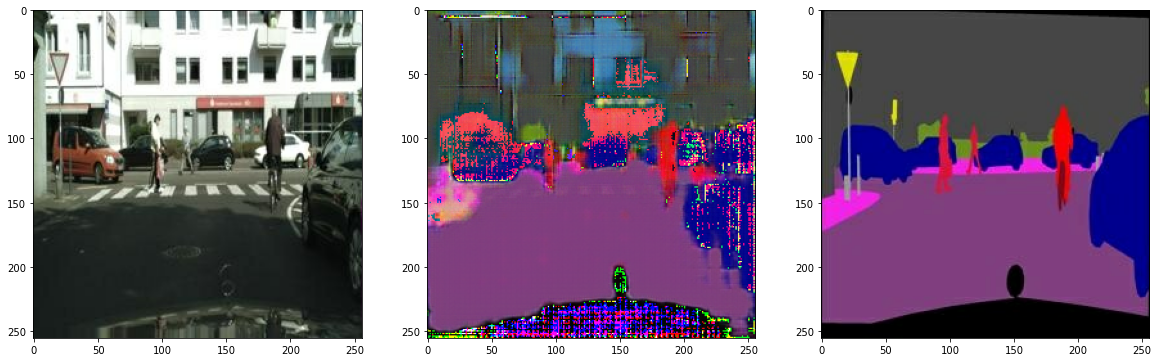

In [57]:
test_ind = 1

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'
f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))